In [1]:
import gluonnlp as nlp
from torch.utils.data import Dataset
import numpy as np
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense,Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


bertmodel, vocab = get_pytorch_kobert_model()


# train, test dataset 불러오기.
dataset_train = nlp.data.TSVDataset('/Users/waterpurifier/Comment_train.txt',encoding='utf-8', field_indices=[2,3], num_discard_samples=1)
dataset_test = nlp.data.TSVDataset('/Users/waterpurifier/Comment_test.txt',encoding='utf-8', field_indices=[2,3], num_discard_samples=1)

token_path = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(token_path, vocab, lower=False)

# BERTDataset
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):

        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        #self.adsf = transform(dataset)[0]
        #print(self.adsf[0])
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]
        
        # 기존의 방식에서 model에 적용할 때 data type이 안맞아서 <list> (int) 로 맞췄음.
        self.sentences = [i[0].tolist() for i in self.sentences]
        self.labels = [i.tolist() for i in self.labels]
        
    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
    
    def __len__(self):
        return (len(self.labels))
    

max_len = 50
vocab_size = len(vocab)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model
using cached model
using cached model


In [3]:
embedding_dim = 64
dropout_prob = (0.5, 0.8)
num_filters = 32

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                  kernel_size = sz,
                  padding = "valid",
                  activation = "relu", 
                  strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z) # , activation="softmax"
model = Model(model_input, model_output)

In [4]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/Users/waterpurifier/CNN.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_CNN = model.fit(data_train.sentences, data_train.labels, batch_size = 64, epochs=5, validation_data = (data_test.sentences, data_test.labels), verbose=2, callbacks=[es, mc])

Epoch 1/5

Epoch 00001: val_acc improved from -inf to 0.88128, saving model to /Users/waterpurifier/CNN_model224.h5
441/441 - 7s - loss: 0.4958 - acc: 0.7709 - val_loss: 0.3321 - val_acc: 0.8813
Epoch 2/5

Epoch 00002: val_acc improved from 0.88128 to 0.88739, saving model to /Users/waterpurifier/CNN_model224.h5
441/441 - 6s - loss: 0.3397 - acc: 0.8671 - val_loss: 0.3035 - val_acc: 0.8874
Epoch 3/5

Epoch 00003: val_acc improved from 0.88739 to 0.89279, saving model to /Users/waterpurifier/CNN_model224.h5
441/441 - 6s - loss: 0.3087 - acc: 0.8802 - val_loss: 0.2994 - val_acc: 0.8928
Epoch 4/5

Epoch 00004: val_acc improved from 0.89279 to 0.89350, saving model to /Users/waterpurifier/CNN_model224.h5
441/441 - 6s - loss: 0.2856 - acc: 0.8891 - val_loss: 0.2890 - val_acc: 0.8935
Epoch 5/5

Epoch 00005: val_acc did not improve from 0.89350
441/441 - 6s - loss: 0.2662 - acc: 0.8984 - val_loss: 0.2897 - val_acc: 0.8928


In [5]:
model.save('/Users/waterpurifier/CNN.h5')
loaded_model_CNN = load_model('/Users/waterpurifier/CNN.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model_CNN.evaluate(data_test.sentences, data_test.labels)[1]))

221/221 [==============================] - 0s 1ms/step - loss: 0.2897 - acc: 0.8928

 테스트 정확도 : 0.8928


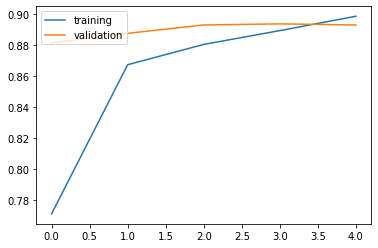

In [7]:
#CNN
import matplotlib.pyplot as plt
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [46]:
class ModelToSentence:
    def __init__(self, new_sentence):
        self.DataFormat = []
        Data = []
        Data.append(new_sentence)
        Data.append(1)
        self.DataFormat.append(Data)
        token_path = get_tokenizer()
        sp = SentencepieceTokenizer(token_path)
        self.sentenceToken = sp(self.DataFormat[0][0])
            
    def getSentence(self):
        return self.DataFormat
    
    def getTokenizer(self):
        return self.sentenceToken
    
    def getVector(self):
        self.sentence = BERTDataset(self.DataFormat, 0,1, tok, max_len, True, False)
        return self.sentence.sentences
    
    def stshow(self):
        count = 0
        Sentence_struct = np.zeros([1, max_len])
        for i in range(len(self.sentence.sentences[0])):
            value = self.sentence.sentences[0][i] / 2 + 0.5
            Sentence_struct[0][i] = value
            
        plt.rcParams['figure.figsize'] = (12, 6)
        # 20개만 짤랐음
        plt.xlim(0,20)
        plt.imshow(Sentence_struct)
    
    def sentiment_predict(self):
        sentence = BERTDataset(self.DataFormat, 0,1, tok, max_len, True, False)
        score = float(loaded_model_CNN.predict(sentence.sentences))
        if(score > 0.5):
            print("CNN : {:.2f}% 확률로 부정적 댓글입니다.\n".format(score * 100))
            return format(score * 100* (-1))
        else:
            print("CNN : {:.2f}% 확률로 일반적 댓글입니다.\n".format((1 - score) * 100))
            return format((1-score)*100)
    

using cached model
[['왜 이러실까요.. ㅠㅠ', 1]]
Tokenizer Result :  ['▁왜', '▁이', '러', '실', '까', '요', '.', '.', '▁', 'ᅲᅲ'] 

Vetor Result     :  [[2, 3466, 3647, 6037, 6738, 5591, 6999, 517, 54, 517, 54, 517, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]] 

CNN : 91.47% 확률로 일반적 댓글입니다.

Model Predict    :  91.47071242332458
----------------------------VecToImg----------------------------
using cached model
[['쟤는 시작한지 4년이나 지났는데 아직도 상승기가 없어ㅋㅋ 고점이 없어서 나락은 안겪어서 좋네 ㅋㅋㅋ병신ㅋ', 1]]
Tokenizer Result :  ['▁', '쟤', '는', '▁시작한', '지', '▁4', '년', '이나', '▁지', '났', '는데', '▁아직', '도', '▁상승', '기가', '▁없어', 'ᄏ', 'ᄏ', '▁고', '점이', '▁없어', '서', '▁나', '락', '은', '▁안', '겪', '어', '서', '▁좋', '네', '▁', 'ᄏ', 'ᄏ', 'ᄏ', '병', '신', 'ᄏ'] 

Vetor Result     :  [[2, 517, 0, 5760, 2989, 7318, 605, 5712, 7098, 4297, 5671, 5761, 3129, 5859, 2670, 5562, 3278, 492, 492, 993, 7224, 3278, 6553, 1370, 6015, 7086, 3135, 5413, 6855, 6553, 4204, 5702, 517, 492, 492, 492, 6361, 

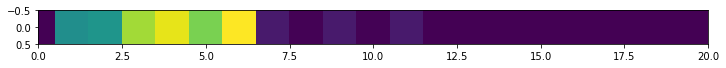

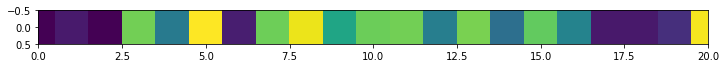

In [51]:
TempText = ModelToSentence('왜 이러실까요.. ㅠㅠ')
print(TempText.getSentence())
print("Tokenizer Result : " , TempText.getTokenizer() , "\n")
print("Vetor Result     : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict    : ", TempText.sentiment_predict())
print("----------------------------VecToImg----------------------------")
plt.figure(1)
TempText.stshow()

TempText = ModelToSentence('쟤는 시작한지 4년이나 지났는데 아직도 상승기가 없어ㅋㅋ 고점이 없어서 나락은 안겪어서 좋네 ㅋㅋㅋ병신ㅋ')
print(TempText.getSentence())
print("Tokenizer Result : " , TempText.getTokenizer() , "\n")
print("Vetor Result     : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict    : ", TempText.sentiment_predict())
print("----------------------------VecToImg----------------------------")
plt.figure(2)
TempText.stshow()


